# Homework 2 - Soccer analytics

#### In this homework, we will go through the analysis of several databases on football teams and clashes.

#### Let us begin with the English championship : the Premier League. We will dig into the database to look for correlations and interesting links between events.

## Libraries

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
import pandas as pd
import re
from dateutil.relativedelta import relativedelta
from seaborn import boxplot
import statistics
import scipy.stats
%matplotlib inline
import json
from pandas.io.json import json_normalize
import seaborn as sns
sns.set()
from matplotlib.patches import Arc, Rectangle, ConnectionPatch
from matplotlib.offsetbox import  OffsetImage
import squarify
from functools import reduce

In [2]:
# For RQ4 and RQ5, a member of the group removed the double slash from the datasets so we used additional datasets
teams = pd.read_json("teams.json")
df_teams = pd.read_json('teams_fixed.json', encoding='utf-8')
df_matches = matches = pd.read_json("matches_England.json")
df_events = events = pd.read_json("events_England.json")
df_coaches = coaches = pd.read_json("coaches.json")
players = pd.read_json("players.json")
df_players = pd.read_json('players_fixed.json',encoding='utf-8')
mliga = pd.read_json("matches_Spain.json")
eliga = pd.read_json("events_Spain.json")
mseriea = pd.read_json("matches_Italy.json")
eseriea = pd.read_json("events_Italy.json")

# RQ1


The biggest winning streak goes to Manchester City
The second biggest winning streak goes to Tottenham Hotspur
The biggest losing streak goes to West Bromwich Albion
The second biggest losing streak goes to Crystal Palace


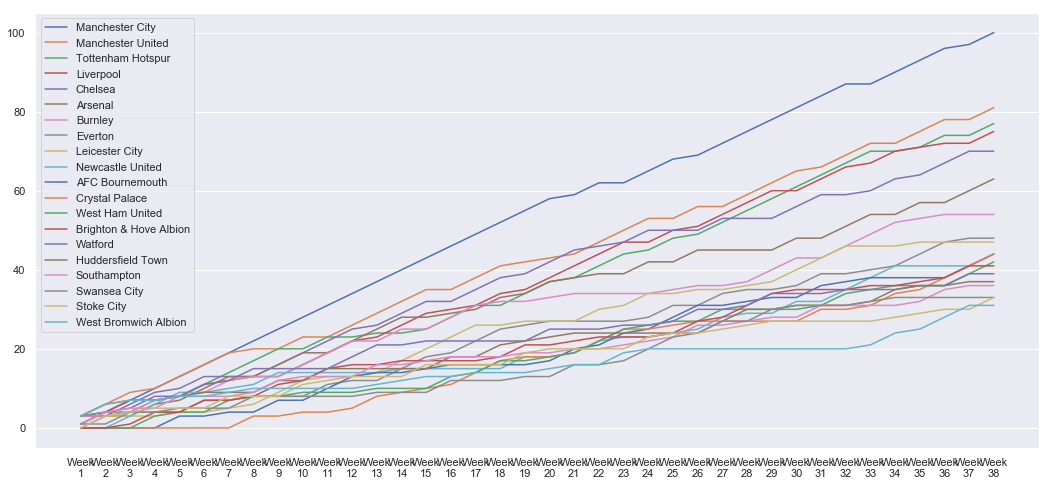

In [66]:
# We could have just considered a dataset with the english teams but it still works with the entire dataset


englishteams = [[0 for _ in range(39)] for _ in range(20)]
eng = [[0 for _ in range(3)] for _ in range(20)] # This list will be useful for the upcoming questions


i = 0

for k in range(len(teams)):
    if (teams["area"][k]["name"] == 'England' or teams["area"][k]["name"] == 'Wales') and teams["name"][k] != 'England' and teams["name"][k] != 'Wales': # We only keep the english teams so that the complexity of the program will decrease
        englishteams[i][0] = teams["name"][k] # We do not want to keep the national team
        eng[i][0] = teams["name"][k]
        i+=1


gameweeks = [i for i in range(1,39)]
for leg in gameweeks:
    games = matches.loc[matches["gameweek"] == leg] # We create a "sub database" with only the games of the given gameweek
    
    for k in range (10):
        games.index = [i for i in range (10)]
        
        if list(games["winner"])[k] != 0 :
            ind = teams.loc[teams["wyId"] == list(games["winner"])[k]].index[0]
           
            for sublist in englishteams :
                if sublist[0] == list(teams["name"])[ind]:
                    englishteams[englishteams.index(sublist)][leg] = 3
        elif list(games["winner"])[k] == 0 : # Let us consider the case on which the match ended on a draw
            firstteam = list(games["label"])[k].split(' - ')[0]# We get the name of the first team of the match which ended on a draw
            secondteam = list(games["label"])[k].split(' - ')[1].split(',')[0] # I recover the name of the second team
           
            for sublist in englishteams :
                if sublist[0] == firstteam :
                    englishteams[englishteams.index(sublist)][leg] = 1
                if sublist[0] == secondteam :
                    englishteams[englishteams.index(sublist)][leg] = 1


# We get back all the points won on each leg, of each team, so that we could use regex

wins = r'[3]+'
losses = r'[0]+'
streakwin = []
streakloss = []
suball = [] # This list will contain all the consecutive 3 points got by a team
for k in range(len(englishteams)):
    w = ''
    suball1 = []
    suball2 = []
    for u in range(1,len(englishteams[k])):
        w+=str(englishteams[k][u])
    for m in re.finditer(wins,w.rstrip()):
        ind = m.group(0)
        suball1.append(len(list(ind)))
    for m in re.finditer(losses,w.rstrip()):
        ind = m.group(0)
        suball2.append(len(list(ind)))
    streakwin.append(max(suball1))
    streakloss.append(max(suball2))

# Let us print out the two teams which had the biggest number of wins in a row (and also the ones with the most losses in a row)


# Let us start with the winning streak :

print("\nThe biggest winning streak goes to " + englishteams[streakwin.index(max(streakwin))][0])

streakwin[streakwin.index(max(streakwin))] = 0

print("The second biggest winning streak goes to " + englishteams[streakwin.index(max(streakwin))][0])
# We "remove" the biggest win streak in order to be able to get the second highest just by using the max method


# As regards the losing streak :

print("The biggest losing streak goes to " + englishteams[streakloss.index(max(streakloss))][0])

streakloss[streakloss.index(max(streakloss))] = 0

print("The second biggest losing streak goes to " + englishteams[streakloss.index(max(streakloss))][0])
# We "remove" the biggest losing streak in order to be able to get the second highest just by using the max method


    
for k in range(len(englishteams)): # We want to update the list of english teams and their scores : at each leg, we want to plot the sum of the points gained on the current leg and all the previous ones
    for i in range(len(englishteams[k])-1,1, -1):
        englishteams[k][i] = sum(englishteams[k][1:i]) + englishteams[k][i] # We do the sum of the consecutive items

englishteams = sorted(englishteams, reverse = True, key = lambda finalpoints : finalpoints[len(englishteams[0])-1])
# We order the teams from the best to the worst (in terms of points, obviously) to plot all of their results in a good order

 
    
# We can now plot the results of each club
game = ["Week"+"\n"+ str(i) for i in range (1,39)]
plt.figure(figsize=(18,8))
for k in range(len(englishteams)):
    plt.plot(game, englishteams[k][1:], label= englishteams[k][0] ,fillstyle='none')       
plt.axes().xaxis.grid() # horizontal lines
plt.legend(loc=2)
plt.show()

We can see that the second longest winning streak is not held by the second team of Premier League (Man Utd). Similarly, the second biggest losing streak is detained by a non-relegated team !

# RQ2

 Let us append to the dataset "Matches" four columns concerning weather or not the team plays at home and other information.

In [4]:
xisq = [] # This list will contain all the contingency tables in order to be used for the chi square test

engteams = teams.loc[(teams["area"] == {'name': 'England', 'id': '0', 'alpha3code': 'XEN', 'alpha2code': ''}) | (teams["area"] == {'name': 'Wales', 'id': '0', 'alpha3code': 'XWA', 'alpha2code': ''})]
# We get all the English (and Welsh) teams from the big dataset gathering all the teams

hometeam = [] # These four lists will enable us to add to the matches dataset four columns : team 1, team 2, the result of team 1 and that of team 2 
awayteam = []
reshome = []
resaway = []


for k in range(len(matches)):
    home = [] # These lists are temporary : they will be sorted to have the right columns to add to the dataset matches
    away = []
    resh = []
    resa = []
    if matches['teamsData'][k][list(matches['teamsData'][k])[0]]['side'] == 'home':
        hometeam.append(int(list(matches['teamsData'][k])[0])) # Id of the home team 
        awayteam.append(int(list(matches['teamsData'][k])[1])) # Id of the away team 
    else :
        hometeam.append(int(list(matches['teamsData'][k])[1])) # Id of the home team 
        awayteam.append(int(list(matches['teamsData'][k])[0])) # Id of the away team 
    if list(matches["winner"])[k] != 0 :
        if matches['winner'][k] == hometeam[k]:
            reshome.append("Win")
            resaway.append("Defeat")
        else :
            reshome.append("Defeat")
            resaway.append("Win")

    elif list(matches["winner"])[k] == 0 : # Let us consider the case on which the match ended on a draw
        reshome.append("Draw")
        resaway.append("Draw")


matches['HomeTeam'] = hometeam
matches['AwayTeam'] = awayteam
matches['ResultHomeTeam'] = reshome
matches['ResultAwayTeam'] = resaway

# Our dataset 'Matches' now has the four additional and wanted columns. To get the contingency table, we will just have to use the crosstab function of pandas

# First, let us recover five english teams

fiveteams = engteams.head(5)
fiveteams.index = [0,1,2,3,4]


for k in range(len(fiveteams)):
    matchest = matches[(matches["HomeTeam"] == fiveteams["wyId"][k]) | (matches["AwayTeam"] == fiveteams["wyId"][k])]
    teamc = fiveteams.loc[[k]]
    firstmerge = pd.merge(teamc, matchest,left_on='wyId', right_on='HomeTeam')
    teamen = firstmerge.append(pd.merge(teamc, matchest,left_on='wyId', right_on='AwayTeam'))
    teamen.index = [i for i in range(38)]
    teamen.drop(columns = ['date','dateutc', "status","type",'seasonId']) # We drop some of the columns to have a "lighter" dataset
    
    winornot = [] # We will add a new column stating if 
    ishome = [] # We will add the information whether or not the club is playing at home
    
    for i in range(len(teamen)):
        if teamen['wyId_x'][i] == teamen['HomeTeam'][i]:
            ishome.append("Home")
            if teamen['ResultHomeTeam'][i] == 'Win':
                winornot.append('Win')
            elif teamen['ResultHomeTeam'][i] == 'Defeat':
                winornot.append("Defeat")
            else:
                winornot.append("Draw")
        else :
            ishome.append("Away")
            if teamen['ResultAwayTeam'][i] == 'Win':
                winornot.append('Win')
            elif teamen['ResultAwayTeam'][i] == 'Defeat':
                winornot.append("Defeat")
            else:
                winornot.append("Draw")
                
    teamen['WinOrNot'] = winornot
    teamen['IsHome'] = ishome # We create two extras columns in order to create the table of contingency easily
    
    teamen.drop(columns = ['date','dateutc', "status","type",'seasonId'])
    # We can now print the table of contingency for each club amongst the 5 chosen :
    
    
# ----------------------------------------------- 

# We append to a list named "xisq" all the contingency tables EXCLUDING the games between the five teams
    
    othert = list(fiveteams["wyId"]) # These are the four other teams. We want to remove the games between the five teams.
    othert.remove(teamen['wyId_x'][0])
    newt = teamen[(teamen["HomeTeam"] != othert[0]) & (teamen["AwayTeam"] != othert[0]) & (teamen["HomeTeam"] != othert[1]) & (teamen["AwayTeam"] != othert[1]) & (teamen["HomeTeam"] != othert[2]) & (teamen["AwayTeam"] != othert[2]) & (teamen["HomeTeam"] != othert[3]) & (teamen["AwayTeam"] != othert[3])]
    
    contingencyspecial = pd.crosstab(newt['WinOrNot'],  
                            newt['IsHome'], 
                                margins = False)
    xisq.append(contingencyspecial)
# -----------------------------------------------   
    
    
    contingencytab = pd.crosstab(teamen['WinOrNot'],  
                            teamen['IsHome'], 
                                margins = False)
    
    
    print("\n")
    
    print("The contingency table for "+ teamen["name"][0] + " is :" + '\n')
    
    print(contingencytab)





The contingency table for Newcastle United is :

IsHome    Away  Home
WinOrNot            
Defeat      11     7
Draw         4     4
Win          4     8


The contingency table for Huddersfield Town is :

IsHome    Away  Home
WinOrNot            
Defeat      11     8
Draw         5     5
Win          3     6


The contingency table for Swansea City is :

IsHome    Away  Home
WinOrNot            
Defeat      11    10
Draw         6     3
Win          2     6


The contingency table for AFC Bournemouth is :

IsHome    Away  Home
WinOrNot            
Defeat       9     7
Draw         6     5
Win          4     7


The contingency table for Brighton & Hove Albion is :

IsHome    Away  Home
WinOrNot            
Defeat      11     4
Draw         6     8
Win          2     7


In order not to affect the contingency tables of each of these teams, we have created new contingency tables excluding the matches between them (essentially for the chi square test).

Now that the contingency tables are printed, we can think that playing on its own field gives way more "chances" for the receiving team to win. Similarly, a team losing way more when she travels.
Moreover, there is something interesting in this particular study : almost all of these teams are "outsiders". They are usually in the second half of the English table. It makes our comment even more reliable : the advantage of the field is also a boost for "weaker" teams. Lastly, it seems that, except for Swansea, all the team have a ratio close to 1 between the number of draws at home and away.

It is important to precise that these are just observations, the chi-square test will enable us to be more accurate on this analysis.


**The hypothesis of the chi-square-test will be the following one :**

- (H0) : " The outcome of the match does not depend on whether a team plays at home or not."


- (H1) : " The outcome of the match depends on whether a team plays at home or not. "

Let us assume that alpha = 0.05. If the p-value happens to be greater than alpha, the test will not be considered as significant.

# Chi-square-test

In [5]:
# To get the p-value of the chi-square test, we will use the homonym function from scipy : 
L = sum(xisq)
print(L)
print(scipy.stats.chi2_contingency(L)[:3])

IsHome    Away  Home
WinOrNot            
Defeat      43    33
Draw        20    18
Win         12    24
(5.421052631578947, 0.06650179655706923, 2)




We have a chi2 statistic value of **5.42** and a degree of freedom equal to 2. In the chart of the chi 2, for alpha = 5% and two degrees of freedom, we read that the critical value is **5.991**.

Hence, the statistic of the test is smaller than the critical value **BUT** the p-value is greater than 0.05 so **the test is not significant**. It means that the probability of rejecting (H0) knowing that (H0) is true is too big.

## We can then say that we fail to reject the hypothesis (H0). Thus, we CANNOT say that there is a dependance between playing at home/away and winning/losing/drawing.



Not being able to reject (H0) **does not mean** that we can accept it. We just cannot conclude about it. 

If we want to know if we can reject (H0), we could calculate the chi square value on a bigger sample (ten teams, for instance).


# RQ3

In [6]:
# RQ3

# Let us introduce a new dataset with only the English teams (we could also have done it before)


allteams = [] # This array will contain the name of the team, the name, last name and date of birth of the coach OF EACH TEAM

for k in range(len(matches)): # Let us go through all the matches of the season
    
    teamone = [0 for _ in range(3)] # This list will store the name of the first team and the information about its coach
    teamtwo = [0 for _ in range(3)] # This list will store the name of the second team and the information about its coach
    
    first = int(list(matches['teamsData'][k])[0]) # Id of the first team 
    firstcoach = int(matches['teamsData'][k][str(first)]['coachId']) # Id of the first coach

    if firstcoach != 0 and firstcoach in list(coaches['wyId']):
        teamone[0] = list(teams[teams['wyId'] == first]['name'])[0]
        teamone[1] = list(coaches[coaches['wyId'] == firstcoach]['shortName'])[0]
        teamone[2] = list(coaches[coaches['wyId'] == firstcoach]['birthDate'])[0]
        
        if teamone[0]!=0 and teamone[1]!=0 and teamone[2]!=0 :
            allteams.append(teamone)
     
    
    second = int(list(matches['teamsData'][k])[1]) # Id of the second team
    secondcoach = int(matches['teamsData'][k][str(second)]['coachId']) # Id of the second coach
    
    if secondcoach != 0 and secondcoach in list(coaches['wyId']):
        teamtwo[0] = list(teams[teams['wyId'] == second]['name'])[0]
        teamtwo[1] = list(coaches[coaches['wyId'] == secondcoach]['shortName'])[0]
        teamtwo[2] = list(coaches[coaches['wyId'] == secondcoach]['birthDate'])[0]
        if teamtwo[0]!=0 and teamtwo[1]!=0 and teamtwo[2]!=0 :    
            allteams.append(teamtwo)

            
# We now want to keep only the unique items in allteams : there is no point in considering multiple times the same coach for the same team

teamandcoach = []
for k in range(len(allteams)):
    if allteams[k] not in teamandcoach :
        teamandcoach.append(allteams[k])

coachesofwholeseason = teamandcoach # This list will be used in RQ6

# As a new instruction has been given for RQ3, we only have to keep the youngest coach of each team

youngestcoaches = []

for k in range(len(englishteams)):
    L = []
    for i in range(len(teamandcoach)):
        if teamandcoach[i][0] == englishteams[k][0]:
            L.append(teamandcoach[i])
    youngestcoaches.append(sorted(L, reverse = True, key = lambda x : x[2])[0])

youngest = sorted(youngestcoaches, reverse = True, key = lambda x : x[2])

age = []
for k in range(len(youngest)):
    dbirth = datetime.strptime(youngest[k][2], '%Y-%m-%d')
    now  = datetime.now()  # We get the date of today
    agecoach = relativedelta(now, dbirth).years
    age.append(agecoach)

coachesofPL = pd.DataFrame(columns = ['Club','Name','Date of birth'])
for k in range(len(youngest)):
    coachesofPL.loc[k+1] = youngest[k]    

coachesofPL["Age"] = age
coachesofPL

,Club,Name,Date of birth,Age
1,AFC Bournemouth,E. Howe,1977-11-29,41
2,Watford,Marco Silva,1977-07-12,42
3,Leicester City,M. Appleton,1975-12-04,43
4,Everton,D. Unsworth,1973-10-16,46
5,Newcastle United,Paco,1973-02-19,46
6,Tottenham Hotspur,M. Pochettino,1972-03-02,47
7,Swansea City,P. Clement,1972-01-08,47
8,Huddersfield Town,D. Wagner,1971-10-19,48
9,Southampton,M. Pellegrino,1971-10-05,48
10,Burnley,S. Dyche,1971-06-28,48


**We have now all the youngest coaches (and their teams) that have been on an English bench during the season 17-18, from the youngest to the oldest**

We can also get the ten youngest ones from the previous dataset :

In [7]:
tenyoungestcoaches = pd.DataFrame(columns = ['Club','Name','Date of birth'])
# We print the ten teams with the youngest coaches, with the name of the coach :

coachesofPL.head(10)


,Club,Name,Date of birth,Age
1,AFC Bournemouth,E. Howe,1977-11-29,41
2,Watford,Marco Silva,1977-07-12,42
3,Leicester City,M. Appleton,1975-12-04,43
4,Everton,D. Unsworth,1973-10-16,46
5,Newcastle United,Paco,1973-02-19,46
6,Tottenham Hotspur,M. Pochettino,1972-03-02,47
7,Swansea City,P. Clement,1972-01-08,47
8,Huddersfield Town,D. Wagner,1971-10-19,48
9,Southampton,M. Pellegrino,1971-10-05,48
10,Burnley,S. Dyche,1971-06-28,48


We can note that most of these young coaches manage clubs from the second half of the Premier League table. This can be explained through the fact that "historic" clubs rely on experienced coaches to finish on the best spots.


 The median of the ages of all the coaches is 48.0 years old


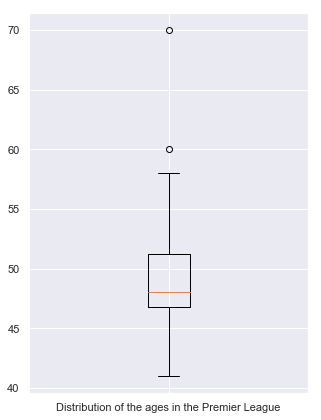

In [8]:
# We now want to print a boxplot of the distribution of the ages


# To plot the ages, we calculate the difference between today's date and the date of birth of each coach.



fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize=(5, 7))
bplot = axes.boxplot(age, labels = ['Distribution of the ages in the Premier League'])

print("\n The median of the ages of all the coaches is " + str(statistics.median(age)) + " years old")

As we can see, a lot of premier league coaches are quite young. Arsène Wenger is a sort of exception among them.

# RQ4

First, we show the modified database of the teams, where the double slashes have been removed :

In [9]:
df_teams.head()

,area,city,name,officialName,type,wyId
0,"{'name': 'England', 'id': '0', 'alpha3code': '...",Newcastle upon Tyne,Newcastle United,Newcastle United FC,club,1613
1,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",Vigo,Celta de Vigo,Real Club Celta de Vigo,club,692
2,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",Barcelona,Espanyol,Reial Club Deportiu Espanyol,club,691
3,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",Vitoria-Gasteiz,Deportivo Alavés,Deportivo Alavés,club,696
4,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",Valencia,Levante,Levante UD,club,695


## We get the list of the IDs of all teams. It will be useful to retrieve all the players of the league.

In [10]:
engteams2 = df_teams.loc[(df_teams["area"] == {'name': 'England', 'id': '0', 'alpha3code': 'XEN', 'alpha2code': ''}) | (df_teams["area"] == {'name': 'Wales', 'id': '0', 'alpha3code': 'XWA', 'alpha2code': ''})]

list_id_teams = engteams2['wyId'].tolist()

engPlayers = df_players.loc[df_players['currentTeamId'].isin(list_id_teams)].reset_index(drop=True)
engPlayers.head()

,birthArea,birthDate,currentNationalTeamId,currentTeamId,firstName,foot,height,lastName,middleName,passportArea,role,shortName,weight,wyId
0,"{'name': 'Belgium', 'id': '56', 'alpha3code': ...",1989-03-02,5629,1624,Toby,right,187,Alderweireld,,"{'name': 'Belgium', 'id': '56', 'alpha3code': ...","{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",T. Alderweireld,91,36
1,"{'name': 'Belgium', 'id': '56', 'alpha3code': ...",1987-04-24,5629,1624,Jan,left,189,Vertonghen,,"{'name': 'Belgium', 'id': '56', 'alpha3code': ...","{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",J. Vertonghen,88,48
2,"{'name': 'Denmark', 'id': '208', 'alpha3code':...",1992-02-14,7712,1624,Christian,right,180,Dannemann Eriksen,,"{'name': 'Denmark', 'id': '208', 'alpha3code':...","{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",C. Eriksen,76,54
3,"{'name': 'Iceland', 'id': '352', 'alpha3code':...",1990-10-27,7839,1646,Johann,left,186,Berg Guðmunds­son,,"{'name': 'Iceland', 'id': '352', 'alpha3code':...","{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",J. Guðmunds­son,77,93
4,"{'name': 'Belgium', 'id': '56', 'alpha3code': ...",1989-08-02,5629,1627,Nacer,right,187,Chadli,,"{'name': 'Morocco', 'id': '504', 'alpha3code':...","{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",N. Chadli,80,261


Now that we retrieved all the players of the PL, we can focus on how to get the accurate and non-accurate passes.

In [11]:
id_passes = [80,81,82,83,84,85,86]
df_passes = df_events.loc[df_events['subEventId'].isin(id_passes)].reset_index(drop=True)
df_passes.head()

,eventId,eventName,eventSec,id,matchId,matchPeriod,playerId,positions,subEventId,subEventName,tags,teamId
0,8,Pass,2.758649,177959171,2499719,1H,25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",85,Simple pass,[{'id': 1801}],1609
1,8,Pass,4.946850,177959172,2499719,1H,370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",83,High pass,[{'id': 1801}],1609
2,8,Pass,6.542188,177959173,2499719,1H,3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",82,Head pass,[{'id': 1801}],1609
3,8,Pass,8.143395,177959174,2499719,1H,120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",82,Head pass,[{'id': 1801}],1609
4,8,Pass,10.302366,177959175,2499719,1H,167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",85,Simple pass,[{'id': 1801}],1609


### We add the pass status (successfully done or not) to our passes table

In [12]:
pass_state = []
ID_SUCCESS = 1801
ID_FAIL = 1802
for index,row in df_passes.iterrows():
    for value in row['tags'][-1].values():
        if value == ID_SUCCESS:
            pass_state.append('successful')
        elif value == ID_FAIL:
            pass_state.append('failed')

In [13]:
# add column with correct pass state
df_passes['pass_status'] = pass_state
df_passes.head()

,eventId,eventName,eventSec,id,matchId,matchPeriod,playerId,positions,subEventId,subEventName,tags,teamId,pass_status
0,8,Pass,2.758649,177959171,2499719,1H,25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",85,Simple pass,[{'id': 1801}],1609,successful
1,8,Pass,4.946850,177959172,2499719,1H,370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",83,High pass,[{'id': 1801}],1609,successful
2,8,Pass,6.542188,177959173,2499719,1H,3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",82,Head pass,[{'id': 1801}],1609,successful
3,8,Pass,8.143395,177959174,2499719,1H,120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",82,Head pass,[{'id': 1801}],1609,successful
4,8,Pass,10.302366,177959175,2499719,1H,167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",85,Simple pass,[{'id': 1801}],1609,successful


Now that we have the modified table of the passes, we will more easily be able to calculate the ratio.

### We join passes table to players table and we sort the table

In [14]:
# passes x players merged
df_passes_players = pd.merge(df_passes, engPlayers, left_on='playerId', right_on='wyId')
df_passes_players.head()

,eventId,eventName,eventSec,id,matchId,matchPeriod,playerId,positions,subEventId,subEventName,...,firstName,foot,height,lastName,middleName,passportArea,role,shortName,weight,wyId
0,8,Pass,2.758649,177959171,2499719,1H,25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",85,Simple pass,...,Alexandre,right,175,Lacazette,,"{'name': 'Guadeloupe', 'id': 312, 'alpha3code'...","{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...",A. Lacazette,73,25413
1,8,Pass,397.881307,177959276,2499719,1H,25413,"[{'y': 70, 'x': 71}, {'y': 63, 'x': 71}]",82,Head pass,...,Alexandre,right,175,Lacazette,,"{'name': 'Guadeloupe', 'id': 312, 'alpha3code'...","{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...",A. Lacazette,73,25413
2,8,Pass,752.105957,177959390,2499719,1H,25413,"[{'y': 38, 'x': 30}, {'y': 0, 'x': 28}]",85,Simple pass,...,Alexandre,right,175,Lacazette,,"{'name': 'Guadeloupe', 'id': 312, 'alpha3code'...","{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...",A. Lacazette,73,25413
3,8,Pass,1253.590895,177959580,2499719,1H,25413,"[{'y': 33, 'x': 72}, {'y': 23, 'x': 61}]",85,Simple pass,...,Alexandre,right,175,Lacazette,,"{'name': 'Guadeloupe', 'id': 312, 'alpha3code'...","{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...",A. Lacazette,73,25413
4,8,Pass,1444.541524,177959669,2499719,1H,25413,"[{'y': 61, 'x': 71}, {'y': 54, 'x': 72}]",85,Simple pass,...,Alexandre,right,175,Lacazette,,"{'name': 'Guadeloupe', 'id': 312, 'alpha3code'...","{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...",A. Lacazette,73,25413


In [15]:
#  list players by short name
list_players = df_passes_players['shortName'].tolist()
# remove duplicates and sort
list_players = sorted(list(dict.fromkeys(list_players)))

### We compute for each player successful and failed passess and the ratio between succesful and failed passess

In [16]:
# for each player, compute the total attempted passed, total successful passes, 
# total failed passes, and ratio between successful and attempted passes


total_list = []
success_list = []
fail_list = []
ratio_list = []

for player in list_players:
    success = 0
    fail = 0
    temp = df_passes_players.loc[(df_passes_players['shortName'] == player)]
    for index,row in temp.iterrows():
        if row['pass_status'] == 'successful':
            success += 1
        elif row['pass_status'] == 'failed':
            fail += 1
    total_passes = success+fail
    ratio = success / total_passes

    total_list.append(total_passes)
    success_list.append(success)
    fail_list.append(fail)
    ratio_list.append(ratio)

###  We apply a treshold based on average passes
### Source: https://www.mirror.co.uk/sport/football/world-cup-2014/world-cup-2014-numbers-goals-3801113
### 390 passes divided by team members: 390/10 = 39 passess on average per player

In [17]:
AVG_PASSES = 39
df_final_players_passes = pd.DataFrame(list(zip(list_players, total_list,success_list,fail_list,ratio_list)), columns = ['shortName', 'total_passes','successful_passes','failed_passes','ratio'])
df_final_players_passes
meaning_passes = df_final_players_passes['total_passes'] > AVG_PASSES
df_final_players_passes.where(meaning_passes, inplace=True)
df_final_players_passes.head()

,shortName,total_passes,successful_passes,failed_passes,ratio
0,A. Barnes,409.0,277.0,132.0,0.677262
1,A. Begović,612.0,507.0,105.0,0.828431
2,A. Carroll,183.0,129.0,54.0,0.704918
3,A. Christensen,1288.0,1211.0,77.0,0.940217
4,A. Cresswell,1350.0,1049.0,301.0,0.777037


###  We print the final table

In [18]:
df_final_players_passes.sort_values(by=['ratio'],ascending=False).head(n=10).reset_index(drop=True)

,shortName,total_passes,successful_passes,failed_passes,ratio
0,J. Stones,1204.0,1175.0,29.0,0.975914
1,F. Delph,1584.0,1497.0,87.0,0.945076
2,V. Kompany,1391.0,1312.0,79.0,0.943206
3,A. Christensen,1288.0,1211.0,77.0,0.940217
4,P. Jones,1057.0,992.0,65.0,0.938505
5,N. Otamendi,2964.0,2779.0,185.0,0.937584
6,Mohamed Elneny,834.0,781.0,53.0,0.936451
7,İ. Gündoğan,1350.0,1263.0,87.0,0.935556
8,V. Lindelöf,729.0,682.0,47.0,0.935528
9,M. Dembélé,1365.0,1273.0,92.0,0.932601


### We can see that the best ratios are detained by players of the leader of the PL. More generally speaking, we can see that this top 10 is EXCLUSIVELY composed of players of the top 6 of the league.

# RQ5

### We begin this part by getting air duels by filtering the dataset of the events

In [19]:
AIR_DUEL_ID = 10 #subEventId for Air Duels
df_air_duels = df_events.loc[df_events['subEventId'] == AIR_DUEL_ID].reset_index(drop=True)
df_air_duels.head()

,eventId,eventName,eventSec,id,matchId,matchPeriod,playerId,positions,subEventId,subEventName,tags,teamId
0,1,Duel,14.765321,177959189,2499719,1H,8013,"[{'y': 15, 'x': 39}, {'y': 20, 'x': 33}]",10,Air duel,"[{'id': 701}, {'id': 1802}]",1631
1,1,Duel,14.765321,177961218,2499719,1H,0,"[{'y': 85, 'x': 61}, {'y': 80, 'x': 67}]",10,Air duel,"[{'id': 703}, {'id': 1801}]",1609
2,1,Duel,21.878309,177959191,2499719,1H,8653,"[{'y': 46, 'x': 29}, {'y': 41, 'x': 50}]",10,Air duel,"[{'id': 703}, {'id': 1801}]",1631
3,1,Duel,22.551816,177959181,2499719,1H,25413,"[{'y': 54, 'x': 71}, {'y': 59, 'x': 50}]",10,Air duel,"[{'id': 701}, {'id': 1802}]",1609
4,1,Duel,47.717508,177959210,2499719,1H,192748,"[{'y': 56, 'x': 60}, {'y': 49, 'x': 56}]",10,Air duel,"[{'id': 703}, {'id': 1801}]",1631


### We distinguish air duels: failed and successful

In [20]:
ID_SUCCESS = 1801
ID_FAIL = 1802

air_duels_state = []

for index,row in df_air_duels.iterrows():
    for value in row['tags'][-1].values():
        if value == ID_SUCCESS:
            air_duels_state.append('successful')
        elif value == ID_FAIL:
            air_duels_state.append('failed')

In [21]:
# we add a column to identify the state
df_air_duels['air_duel_status'] = air_duels_state

### Now that we have the status of the air duels, we can merge the table of the players with the air duels table

In [22]:
df_air_duels_players = pd.merge(df_air_duels, df_players, left_on = 'playerId', right_on='wyId')
df_air_duels_players.head()

,eventId,eventName,eventSec,id,matchId,matchPeriod,playerId,positions,subEventId,subEventName,...,firstName,foot,height,lastName,middleName,passportArea,role,shortName,weight,wyId
0,1,Duel,14.765321,177959189,2499719,1H,8013,"[{'y': 15, 'x': 39}, {'y': 20, 'x': 33}]",10,Air duel,...,Marc,right,175,Albrighton,,"{'name': 'England', 'id': 0, 'alpha3code': 'XE...","{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",M. Albrighton,74,8013
1,1,Duel,1849.848781,177960720,2499719,2H,8013,"[{'y': 22, 'x': 68}, {'y': 0, 'x': 75}]",10,Air duel,...,Marc,right,175,Albrighton,,"{'name': 'England', 'id': 0, 'alpha3code': 'XE...","{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",M. Albrighton,74,8013
2,1,Duel,1576.643898,180119076,2499732,2H,8013,"[{'y': 21, 'x': 29}, {'y': 27, 'x': 32}]",10,Air duel,...,Marc,right,175,Albrighton,,"{'name': 'England', 'id': 0, 'alpha3code': 'XE...","{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",M. Albrighton,74,8013
3,1,Duel,2515.660502,180119240,2499732,2H,8013,"[{'y': 5, 'x': 70}, {'y': 0, 'x': 48}]",10,Air duel,...,Marc,right,175,Albrighton,,"{'name': 'England', 'id': 0, 'alpha3code': 'XE...","{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",M. Albrighton,74,8013
4,1,Duel,229.451539,185749853,2499753,1H,8013,"[{'y': 30, 'x': 90}, {'y': 36, 'x': 89}]",10,Air duel,...,Marc,right,175,Albrighton,,"{'name': 'England', 'id': 0, 'alpha3code': 'XE...","{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",M. Albrighton,74,8013


In [23]:
# we organize the list by shortname
list_players_air_duels = df_air_duels_players['shortName'].tolist()
# we remove duplicates and sort
list_players_air_duels = sorted(list(dict.fromkeys(list_players_air_duels)))

### We retrieved the list of the names of the players to be more easily compute the ratio of their successful and failed air duels.

In [24]:
total_list = []
success_list = []
fail_list = []
ratio_list = []

for player in list_players_air_duels:
    success = 0
    fail = 0
    temp = df_air_duels_players.loc[(df_air_duels_players['shortName'] == player)]
    for index,row in temp.iterrows():
        if row['air_duel_status'] == 'successful':
            success += 1
        elif row['air_duel_status'] == 'failed':
            fail += 1
    total_air_duels = success+fail
    # treshold
    ratio = success / total_air_duels

    total_list.append(total_air_duels)
    success_list.append(success)
    fail_list.append(fail)
    ratio_list.append(ratio)

### We organize the table to view better the data

In [25]:
df_final_players_air_duels = pd.DataFrame(list(zip(list_players_air_duels, total_list,success_list,fail_list,ratio_list)), columns = ['shortName', 'total_air_duels','successful_air_duels','failed_air_duels','ratio'])
df_final_players_air_duels.head()

,shortName,total_air_duels,successful_air_duels,failed_air_duels,ratio
0,A. Ayew,153,59,94,0.385621
1,A. Barnes,371,137,234,0.369272
2,A. Begović,22,20,2,0.909091
3,A. Carrillo,48,15,33,0.312500
4,A. Carroll,153,100,53,0.653595


### We can now sort the table to get the top 10 players regarding their ratio

In [26]:
df_final_players_air_duels.sort_values(by=['ratio'],ascending=False).head(n=10).reset_index(drop=True)

,shortName,total_air_duels,successful_air_duels,failed_air_duels,ratio
0,H. Barnes,1,1,0,1.0
1,Jesús Gámez,1,1,0,1.0
2,C. Bravo,2,2,0,1.0
3,M. Hefele,1,1,0,1.0
4,J. Speroni,2,2,0,1.0
5,J. Simpson,1,1,0,1.0
6,J. Pied,3,3,0,1.0
7,M. Ryan,19,19,0,1.0
8,M. Vorm,1,1,0,1.0
9,C. Musonda,1,1,0,1.0


#### This result is not really meaningful as having a ratio of 1 while having only taking 1 ball by head is not an achievement

### We found that there are ~ 5 air duels per game, so we apply a treshold

In [27]:
APPROX_AIR_DUELS = 5
meaning_passes = df_final_players_air_duels['total_air_duels'] >= APPROX_AIR_DUELS
df_final_players_air_duels.where(meaning_passes, inplace=True)
df_final_players_air_duels.sort_values(by=['ratio'],ascending=False).head(n=10).reset_index(drop=True)

,shortName,total_air_duels,successful_air_duels,failed_air_duels,ratio
0,W. Hennessey,14.0,14.0,0.0,1.000000
1,J. Butland,12.0,12.0,0.0,1.000000
2,K. Darlow,10.0,10.0,0.0,1.000000
3,M. Dúbravka,5.0,5.0,0.0,1.000000
4,M. Ryan,19.0,19.0,0.0,1.000000
5,D. Ospina,6.0,6.0,0.0,1.000000
6,J. Hart,8.0,8.0,0.0,1.000000
7,O. Karnezis,6.0,6.0,0.0,1.000000
8,B. Foster,10.0,10.0,0.0,1.000000
9,J. Pickford,27.0,26.0,1.0,0.962963


### We add the player height to our table by joining player table and air duels table

In [28]:
df_final_height = pd.merge(df_final_players_air_duels, df_players[['shortName','height']], left_on='shortName', right_on='shortName')
df_final_height.head()

,shortName,total_air_duels,successful_air_duels,failed_air_duels,ratio,height
0,A. Ayew,153.0,59.0,94.0,0.385621,176
1,A. Barnes,371.0,137.0,234.0,0.369272,186
2,A. Begović,22.0,20.0,2.0,0.909091,199
3,A. Carrillo,48.0,15.0,33.0,0.312500,181
4,A. Carroll,153.0,100.0,53.0,0.653595,193


#### We can note that André Ayew succeeded in taking quite a lot of balls by his head despite not being really tall.

### We define colors for each height range

In [29]:
temp_height_list = df_final_height['height'].tolist()
temp_ratio_list = df_final_height['ratio'].tolist()
colors = []

for height in temp_height_list:
    if height < 160:
        colors.append('yellow')
    elif height < 170:
        colors.append('orange')
    elif height < 180:
        colors.append('red')
    elif height < 190:
        colors.append('purple')
    elif height < 200:
        colors.append('green')
    else:
        colors.append('blue')

### We can now plot our results, by distinguishing players regarding their heights (It looks a bit like plotting the result of a clustering with the k-means method)

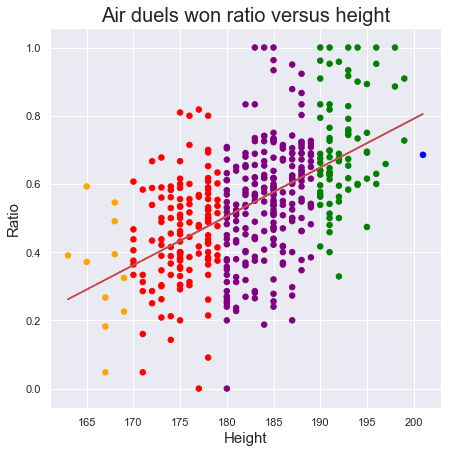

In [30]:
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(temp_height_list,temp_ratio_list)

def predict(x):
   return slope * x + intercept

fitLine = predict(np.array(temp_height_list))
fig = plt.figure(1, figsize=(7, 7))
plt.scatter(temp_height_list,y=temp_ratio_list,s=30,c=colors) 
plt.plot(temp_height_list, fitLine, c='r')
plt.title('Air duels won ratio versus height',size=20)
plt.xlabel('Height',size=15)
plt.ylabel('Ratio',size=15)
plt.show()

#### Logically, we can see that the ratio is closer to 1 when the player's height is close to 1m90. It sounds logical but we can still see that players smaller than 1m80 manage to have a good ratio, surely thanks to their ability to just high and being strong physically.

# RQ6

In this additional part, we are going to focus on the correlation between having several coaches and being relegated from the Premier League (between the 18th and the 20th post). Similarly, we will see if there is a correlation between being an experienced (understood as being quite old) coach and finishing in the European spots (from the 1st to the 6th spot).

Let us create a condition where a coach is considered as old when he is 50 years old or more (this is a bit greater than the median of the coaches' ages).

In [31]:
allcoaches = pd.DataFrame(columns = ["Club","Coach","Age","IsOld","Rank","QualificationOrRelegation" ])


agec = []

for k in range(len(coachesofwholeseason)):
    dbirth = datetime.strptime(coachesofwholeseason[k][2], '%Y-%m-%d')
    now  = datetime.now()  # We get the date of today
    agecoach = relativedelta(now, dbirth).years
    for i in range(len(englishteams)):
        if coachesofwholeseason[k][0] == englishteams[i][0] :
            if agecoach >= 50 :
                if (i+1) >= 1 and (i+1) <= 6:
                    allcoaches.loc[k+1]= [coachesofwholeseason[k][0], coachesofwholeseason[k][1],agecoach,"Old" ,i+1, "European competition"]
                elif (i+1)>=18:
                    allcoaches.loc[k+1]= [coachesofwholeseason[k][0], coachesofwholeseason[k][1],agecoach,"Old" ,i+1, "Relegated"]
                else :
                    allcoaches.loc[k+1]= [coachesofwholeseason[k][0], coachesofwholeseason[k][1],agecoach,"Old" ,i+1, "Maintained in PL"]
            else:
                if (i+1) >= 1 and (i+1) <= 6:
                    allcoaches.loc[k+1]= [coachesofwholeseason[k][0], coachesofwholeseason[k][1],agecoach,"Young" ,i+1, "European competition"]
                elif (i+1)>=18:
                    allcoaches.loc[k+1]= [coachesofwholeseason[k][0], coachesofwholeseason[k][1],agecoach,"Young" ,i+1, "Relegated"]
                else :
                    allcoaches.loc[k+1]= [coachesofwholeseason[k][0], coachesofwholeseason[k][1],agecoach,"Young" ,i+1, "Maintained in PL"]
                    
allcoaches = allcoaches.sort_values(by ='Rank' )
allcoaches.index = [i for i in range(1, len(allcoaches)+1)]


# For the second part of RQ6, we will add a column containing the number of coaches of each club
nbofcoaches = []
for k in range(1,len(allcoaches)+1):
    nbofcoaches.append(len(allcoaches[allcoaches["Club"] == allcoaches["Club"][k]]))

allcoaches["NbOfCoaches"] = nbofcoaches

**We can now show the dataset composed of all the teams and all the coaches they had on the 2017-2018 season :**

In [32]:
allcoaches

,Club,Coach,Age,IsOld,Rank,QualificationOrRelegation,NbOfCoaches
1,Manchester City,Guardiola,48,Young,1,European competition,1
2,Manchester United,José Mourinho,56,Old,2,European competition,1
3,Tottenham Hotspur,M. Pochettino,47,Young,3,European competition,1
4,Liverpool,J. Klopp,52,Old,4,European competition,1
5,Chelsea,A. Conte,50,Old,5,European competition,1
6,Arsenal,A. Wenger,70,Old,6,European competition,1
7,Burnley,S. Dyche,48,Young,7,Maintained in PL,1
8,Everton,R. Koeman,56,Old,8,Maintained in PL,3
9,Everton,D. Unsworth,46,Young,8,Maintained in PL,3
10,Everton,S. Allardyce,65,Old,8,Maintained in PL,3


Let us look at the contingency table between the fact that the coach is old or not and the final outcome of his team.

In [33]:
cross = pd.crosstab(allcoaches["IsOld"], allcoaches["QualificationOrRelegation"])
cross

QualificationOrRelegation,European competition,Maintained in PL,Relegated
IsOld,,,
Old,4,10,6
Young,2,10,1


With H0 the hypothesis according to which being old and the outcome of the team of a coach are independent, we can directly see that this hypothesis cannot be reject, thanks to the chi square test (the p-value being way too big) :

In [34]:
print(scipy.stats.chi2_contingency(cross)[:3])

(2.8829670329670334, 0.23657653303564755, 2)


Still, we can see that 6 coaches out of 7 who had coached the relegated teams were "old" (see the criteria we decided to decide on the old age of a coach) ! Nevertheless, we can see that 4 coaches out of 6 have qualified their teams to European clashes.

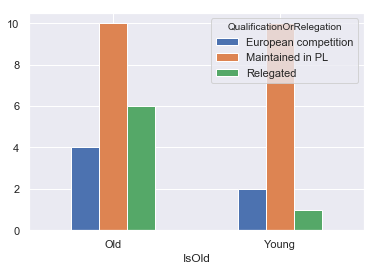

In [35]:
cross.plot.bar(rot=0)

### Before moving to the core research questions, let us see the link between having several coaches and being maintained in the PL

In [36]:
uniqueteams = pd.DataFrame(columns = allcoaches.columns)

for k in range(1,len(allcoaches)+1): 
    if allcoaches["Club"][k] not in list(uniqueteams["Club"]):
        uniqueteams.loc[k] = (list(allcoaches.loc[k]))
uniqueteams.index = [i for i in range (1,len(uniqueteams)+1)]

# We can actually drop the rank, as the index already indicates the rank of the team

uniqueteams = uniqueteams.drop(columns = ['Coach','Rank',"IsOld","Age"])
uniqueteams

,Club,QualificationOrRelegation,NbOfCoaches
1,Manchester City,European competition,1
2,Manchester United,European competition,1
3,Tottenham Hotspur,European competition,1
4,Liverpool,European competition,1
5,Chelsea,European competition,1
6,Arsenal,European competition,1
7,Burnley,Maintained in PL,1
8,Everton,Maintained in PL,3
9,Leicester City,Maintained in PL,3
10,Newcastle United,Maintained in PL,2


In [37]:
cross2 = pd.crosstab(uniqueteams["QualificationOrRelegation"], uniqueteams["NbOfCoaches"])
cross2

NbOfCoaches,1,2,3
QualificationOrRelegation,,,
European competition,6,0,0
Maintained in PL,4,5,2
Relegated,0,2,1


We can see that a team still got relegated despite having 3 coaches on this season ! On the opposite side of the table, we can see that the first 6 teams had bet on stability : the relied on a single coach during the whole season.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000029951DFA390>,
      dtype=object)

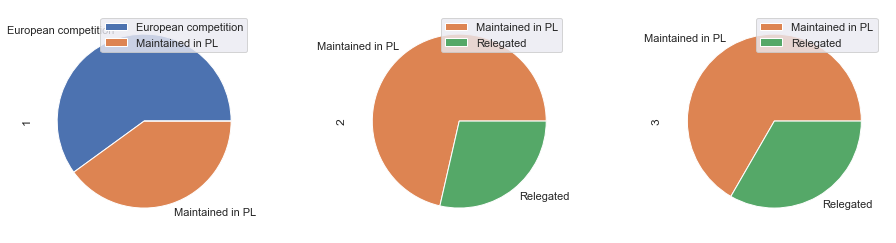

In [38]:
cross2.plot.pie(subplots=True, figsize=(16, 4))


- **For the teams with one coach** : We can see that NO team with one manager was relegated. More than half of these coaches qualified to European competitions (Champions League or Europa League).

- **For the teams with two coaches** : Most of them maintained in the PL but an important proportion of them were relegated.

- **For the teams with three coaches** : The part of relegated teams is a bit more important but the example of Leicester is different : the changes of coaches enabled the team to go from the 18th position to the 9th.

# Core research questions

In this part, we will go deaper in our analysis. Let us begin with CRQ1.

# CRQ1

First, we are focusing on the intervals in which teams are scoring goals.

In [39]:
goalsteam = pd.DataFrame(columns = ["Team","IdTeam","[0-9]","[9.1-18]","[18.1-27]","[27.1-36]","[36.1-45]","45+","[45-54]","[54.1-63]","[63.1-72]","[72.1-81]","[81.1-90]","90+"])
goalsplayer = pd.DataFrame(columns = ["NamePlayer","IdPlayer","[0-9]","[9.1-18]","[18.1-27]","[27.1-36]","[36.1-45]","45+","[45-54]","[54.1-63]","[63.1-72]","[72.1-81]","[81.1-90]","90+"])

goalsteam["Team"] = list(uniqueteams["Club"])

idteam = []
nameseng = list(goalsteam["Team"])
for k in range(len(nameseng)):
    idteam.append(list(engteams[engteams["name"] == nameseng[k]]['wyId'])[0])
    
goalsteam["IdTeam"]= idteam
goalsteam = goalsteam.fillna(0)

**This dataset will be used to store the statistics on the number of goals of each club !**

Let us now jump into the analyze of the goals. As the dataset of events is huge, we will have to be careful in order not to go over all of it once, but by sequence.

**We tried to get the own goals in order to count them as goals for the other team but the dataset has a special scheme. It is difficult to discern an own goal from a saved attempt.** When we considered the "saved attempts", too many goals were counted (around 130 for Man City). 

We will sacrifice these own goals. Anyway, the biggest amount of own goals a club has profited of is equal to 5 goals. The study is not compromised for the omission of one goal out of 30 and more.

In [40]:
liste = []
allgoalsplay = [] # This list will contain ALL the goals and the id of the player who scored each one of them
goalsbyplayer = []

for u in range(len(goalsteam)):
    idteam = goalsteam["IdTeam"][u]
    eventsteam = events[events["teamId"] == idteam]
    eventsteam = eventsteam.merge(matches[["HomeTeam","AwayTeam","wyId","teamsData","gameweek"]], left_on = 'matchId', right_on = 'wyId')
    eventsteam = eventsteam[(eventsteam["eventId"] == 10) |(eventsteam["eventId"] == 3)] 
    eventsteam.index = [i for i in range(len(eventsteam))]
    
    
    
    first = 0 # These will be used to count the number of goals scores in each interval.
    second= 0
    third= 0
    fourth = 0
    fifth= 0
    sixth= 0
    seventh= 0
    eighth= 0
    nineth= 0
    tenth = 0
    eleventh = 0
    twelfth= 0

   
    for k in range(len(eventsteam)):
        
        if len(eventsteam["tags"][k])>0:
            for i in range(len(eventsteam["tags"][k])):
                goalornot = 0
                idevent = eventsteam["tags"][k][i]["id"]

                if idevent == 101: 
                    # We take as hypothesis that a goal can be scored from a free kick or a shot (either by foot or via a head knock)
                    goalornot = 1
                    break

            if goalornot == 1 :
                minute = eventsteam["eventSec"][k]/60
                playergoal = eventsteam["playerId"][k]
                rete = [playergoal]+[0 for _ in range(12)] # This list will store the goal with the interval in which it was scored
                # We also want to get the id of the player and when he scored
                
                
                
                if eventsteam["matchPeriod"][k] == "1H":
                    
                    if 0<=minute<=9:
                        first+=1
                        rete[1] = 1 
                    if 9<minute<=18:
                        second+=1
                        rete[2] = 1 

                    if 18<minute<=27:
                        third+=1
                        rete[3] = 1 
                   
                    if 27<minute<=36:
                        fourth+=1
                        rete[4] = 1 
                   
                    if 36<minute<45:
                        fifth+=1
                        rete[5] = 1 
                  
                    if minute>=45:
                        sixth+=1
                        rete[6] = 1 
              
                elif eventsteam["matchPeriod"][k] == "2H":
                    if 0<=minute<=9:
                        seventh+=1
                        rete[7] = 1 
                    
                    if 9<minute<=18:
                        eighth+=1
                        rete[8] = 1 
                    
                    if 18<minute<=27:
                        nineth+=1
                        rete[9] = 1 
                   
                    if 27<minute<=36:
                        tenth+=1
                        rete[10] = 1 
                    
                    if 36<minute<45:
                        eleventh+=1
                        rete[11] = 1 
                    
                    if minute>=45:
                        twelfth+=1
                        rete[12] = 1 
        
                allgoalsplay.append(rete)

    
    liste.append([first,second,third,fourth,fifth,sixth,seventh,eighth,nineth,tenth,eleventh,twelfth])

# As this code is extremely dense and we did not figure out how to lighten it, the time of execution will be quite big.
# We could have ignored the own goals, what would have enabled us to gain execution time but it would affect our comparison between the teams.


import timeit
start_time = timeit.default_timer()
# code you want to evaluate
elapsed = timeit.default_timer() - start_time
print(elapsed)

4.939999999464817e-05


Let us explain all this a bit. After having recovered the goals scored, we looked at the minute in which the goal was scored.

We could thus fill the dataset gathering the information regarding the goals of each team !

**PS : It is important to precise that the conditions we used to reduce the dataset have been decided after having seen that, for instance, all the goals where scored by a shot, a free-kick/penalty or an own goal of the other team.** It enabled us to reduce a bit the complexity of the program.

In [41]:
transposed = np.transpose(liste) # We need to transpose the list to push it in the goalsteam dataset

distribgoals = pd.DataFrame(columns = list(goalsteam.columns)[2:]) # This dataset will be used to show the distribution of the goals on the different intervals

columns = list(goalsteam.columns)
for k in range(2,len(columns)): # We do not want to recover the name and the id of the team so we directly begin with the goals columns
    goalsteam[columns[k]] = transposed[k-2]
    distribgoals[columns[k]] = [sum(transposed[k-2])]
goalsteam.index = [i for i in range(1,len(goalsteam)+1)]
goalsteam

,Team,IdTeam,[0-9],[9.1-18],[18.1-27],[27.1-36],[36.1-45],45+,[45-54],[54.1-63],[63.1-72],[72.1-81],[81.1-90],90+
1,Manchester City,1625,3,11,13,9,6,1,15,8,8,10,13,5
2,Manchester United,1611,5,3,7,6,5,3,6,7,6,6,9,4
3,Tottenham Hotspur,1624,5,5,5,3,5,2,15,8,6,7,5,4
4,Liverpool,1612,7,3,9,7,8,1,9,10,10,9,7,2
5,Chelsea,1610,6,3,8,6,4,1,4,6,6,6,9,1
6,Arsenal,1609,6,6,6,3,7,2,10,7,7,5,11,3
7,Burnley,1646,4,0,4,2,6,0,0,2,6,6,4,1
8,Everton,1623,1,2,3,2,3,3,4,2,6,10,3,3
9,Leicester City,1631,6,6,4,4,3,2,5,6,4,4,3,6
10,Newcastle United,1613,2,5,4,4,0,1,2,6,7,5,2,0


Text(0, 0.5, 'Number of goals')

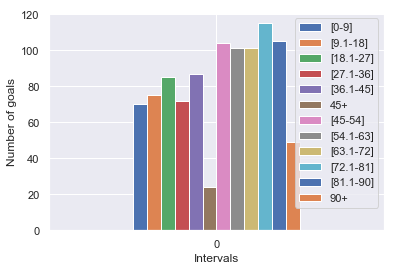

In [42]:
plot = distribgoals.plot.bar(rot=0)
plot.set_xlabel("Intervals", fontsize=12)
plot.set_ylabel("Number of goals", fontsize=12)

We can see that the interval in which the biggest amount of goals are scored is between the 71st and the 80th minute. It seems logical, since coaches make replacements in the few previous minutes. 

We can see that few goals are scored in the garbage time of the first half. But when we look at the end of the match...

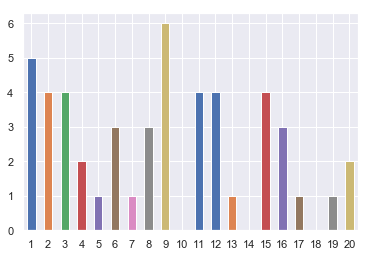

In [43]:
plot = goalsteam["90+"].plot.bar(rot=0)

We can see that Leicester has scored 6 goals after the 90th minute. To support what we said in RQ6, it seems that the club maintained in the PL also thanks to many come backs in the last minutes.

Another funny statistic is that Manchester United still had a bit of the heritage of Ferguson. They still scored 4 goals after the 90th, moment of the match called the "Fergie time".

**Let us now show the 10 teams that score the most between minute 81 and minute 90.**

In [44]:
# We can rank the dataset goalsteam by the column [81.1-90]

newgoalsteam = goalsteam.sort_values(by ='[81.1-90]', ascending = False)
newgoalsteam.index = [i for i in range(1,len(newgoalsteam)+1)]
newgoalsteam[:10]

,Team,IdTeam,[0-9],[9.1-18],[18.1-27],[27.1-36],[36.1-45],45+,[45-54],[54.1-63],[63.1-72],[72.1-81],[81.1-90],90+
1,Manchester City,1625,3,11,13,9,6,1,15,8,8,10,13,5
2,Arsenal,1609,6,6,6,3,7,2,10,7,7,5,11,3
3,Manchester United,1611,5,3,7,6,5,3,6,7,6,6,9,4
4,Chelsea,1610,6,3,8,6,4,1,4,6,6,6,9,1
5,Watford,1644,3,5,1,2,4,1,3,3,5,4,7,4
6,Liverpool,1612,7,3,9,7,8,1,9,10,10,9,7,2
7,Crystal Palace,1628,2,4,5,1,5,0,4,3,4,5,7,4
8,West Ham United,1633,3,2,3,3,8,1,1,6,6,8,6,1
9,AFC Bournemouth,1659,1,5,1,5,3,2,2,1,8,8,5,4
10,Tottenham Hotspur,1624,5,5,5,3,5,2,15,8,6,7,5,4


We can see that really well ranked teams have scored a lot during the last 9 minutes (excluding the stoppage time).

The 6 teams of the Top 6 of the PL are in this ranking. The link is even more important when we focus on the champion, Manchester City. Even though they seem to score at any time of the match, there is a peak at the end of it. It can be explained by the good substitutions made or other factors.

**Now that we dealt with the clubs, let us focus on the players. We filled some lists we are going to exploit to build a dataframe of all the players who have scored goals, and all their goals in the right interval of time.**

In [45]:
segnato = list(set([allgoalsplay[i][0] for i in range(len(allgoalsplay))])) # We get the ideas of each player in order to gather all his goals

for k in range(len(segnato)):
    listplayergoals = np.array([allgoalsplay[i][1:] for i in range(len(allgoalsplay)) if allgoalsplay[i][0] == segnato[k]]) # We store in a list all the goals of a given player
    listplayergoals = list(sum(listplayergoals))# We finally get the id of the player and all his goals during the twelve intervals
    listplayergoals.insert(0,segnato[k])
    goalsbyplayer.append(listplayergoals)

Now that we have all the goals scored by the players, we can build a dataset based on this list. Let us first recover the names of the players (it seems that the conversion of the database to a json file has not enabled to take special characters into consideration. Some names of players are not well written).

In [46]:
namesplayers = []

numberofgoals = [] # This list will store the total number of goals of each players

for k in range(len(goalsbyplayer)):
    namesplayers.append(list(players[players["wyId"] == goalsbyplayer[k][0]]["shortName"])[0])
    numberofgoals.append(sum(goalsbyplayer[k][1:]))
    
transposedplayers = np.transpose(goalsbyplayer) 

columnsplayer = list(goalsplayer.columns)
goalsplayer["NamePlayer"] = namesplayers # We first put all the names of the players who have scored goals.

for k in range(1,len(columnsplayer)):
    goalsplayer[columnsplayer[k]] = transposedplayers[k-1]
    
goalsplayer["Total"] = numberofgoals

aguero = goalsplayer[goalsplayer["IdPlayer"] == 8325] # We recover the information of Aguero for the end of this question

goalsplayer.head(10) # We now have a brand new dataset with the names of all the scorers and their goals split on different intervals of time

,NamePlayer,IdPlayer,[0-9],[9.1-18],[18.1-27],[27.1-36],[36.1-45],45+,[45-54],[54.1-63],[63.1-72],[72.1-81],[81.1-90],90+,Total
0,H. Saivet,25604,0,1,0,0,0,0,0,0,0,0,0,0,1
1,D. Gray,283142,1,0,0,1,0,0,0,1,0,0,0,0,3
2,Sung-Yeung Ki,61962,1,0,0,0,0,0,0,0,0,1,0,0,2
3,M. Ritchie,9227,0,0,0,0,0,0,0,1,2,0,0,0,3
4,A. Robertson,222220,0,0,0,0,0,0,0,0,0,0,1,0,1
5,H. Kane,8717,4,1,2,2,2,0,7,2,3,4,1,1,29
6,J. Ibe,9739,0,0,0,0,0,0,0,0,0,2,0,0,2
7,V. Wanyama,61967,0,0,0,0,0,0,0,0,0,1,0,0,1
8,A. Carrillo,70156,0,1,0,0,0,0,0,0,0,0,0,0,1
9,S. Clucas,10252,0,0,1,1,0,0,0,0,0,0,1,0,3


As we want to see which players were able to score in eight different intervals of time, we are going to count the number of intervals in which each player has scored.

In [47]:
columns = list(goalsplayer.columns)[2:]

numberofintervals = [] # This list will be added to the goalsplayer dataset to determine whether or not a player reaches our condition of scoring on 8 different intervals
for k in range(len(goalsplayer)):
    count = 0
    for i in range(len(columns)-1):
        if goalsplayer[columns[i]][k] !=0:
            count +=1
    numberofintervals.append(count)
    
    
goalsplayer["NumberOfIntervals"] = numberofintervals

### Now that we have our complete dataset with all the required information, we can restrict our dataset to the players who have scored in 8 different intervals :

In [48]:
goalsplayer = goalsplayer[goalsplayer["NumberOfIntervals"]>=8].sort_values(by = 'Total', ascending = False)
goalsplayer.index = [i for i in range(1,len(goalsplayer)+1)]
goalsplayer

,NamePlayer,IdPlayer,[0-9],[9.1-18],[18.1-27],[27.1-36],[36.1-45],45+,[45-54],[54.1-63],[63.1-72],[72.1-81],[81.1-90],90+,Total,NumberOfIntervals
1,Mohamed Salah,120353,2,1,3,2,6,0,3,2,4,5,3,1,32,11
2,H. Kane,8717,4,1,2,2,2,0,7,2,3,4,1,1,29,11
3,J. Vardy,12829,2,3,3,1,1,0,1,2,3,2,1,1,20,11
4,R. Sterling,11066,2,1,1,1,1,0,2,1,2,1,4,2,18,11
5,R. Lukaku,7905,1,0,3,1,1,0,1,2,3,2,2,0,16,9
6,Roberto Firmino,15808,1,1,0,1,0,1,3,4,3,0,1,0,15,8
7,A. Lacazette,25413,2,1,3,0,0,1,1,0,2,1,3,0,14,8
8,Gabriel Jesus,340386,0,2,2,0,2,1,2,1,0,1,1,1,13,9
9,R. Mahrez,26150,0,2,1,0,1,1,1,2,0,1,1,2,12,9
10,\u00c1lvaro Morata,3324,1,1,0,2,2,0,1,1,1,1,1,0,11,9


These players are almost exclusively members of the top 6 of the Premier League (except Wilfried Zaha and Vardy).

We can also underline something surprising : the third best scorer, **Sergio Aguero**, is not in this table. It proves that scoring a lot of goals does not imply scoring in a lot of different intervals.
We could even verify the correlation between being a forward of a "top team" and scoring in multiple intervals we will not go further in this analysis.

In [49]:
aguero

,NamePlayer,IdPlayer,[0-9],[9.1-18],[18.1-27],[27.1-36],[36.1-45],45+,[45-54],[54.1-63],[63.1-72],[72.1-81],[81.1-90],90+,Total
56,S. Ag\u00fcero,8325,0,0,3,3,0,0,4,2,1,4,4,0,21


As we can see, he scored several goals in some intervals but failed to score in some others. What we said above, about scoring a lot of goals without having them split on all the moments of a match, seems to be verified.

#### To conclude this question, we can say that PL teams score the most between the 71th and the 80th minutes. Some teams seem to be more able than others to score at the end of the game (see the example of Leicester).

#### From a technical point of view, we can say that these datasets are quite tricky to handle. As a lot of parameters are set to design a general event (ex : a goal), we can miss some data by not pointing towards the right values. Similarly, we can take too much values into consideration if we don't target with precision the right parameters (ex : an event that seems to lead to a goal but with another Id like "saved attempt").

### We can now move on to CRQ2

# CRQ2

In this question, we will focus on the visualization of the movements and differents main events on a football pitch. We will consider two games : Real Madrid - Barca and Juventus - Napoli.

First, we have to draw the football field. We used the link you provided us to copy the code and use it in this exercise.

Link : https://towardsdatascience.com/advanced-sports-visualization-with-pandas-matplotlib-and-seaborn-9c16df80a81b

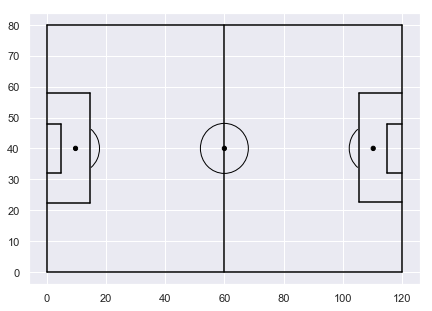

In [50]:

def draw_pitch(ax):
    # size of the pitch is 120, 80
    #Create figure

    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,80], color="black")
    plt.plot([0,120],[80,80], color="black")
    plt.plot([120,120],[80,0], color="black")
    plt.plot([120,0],[0,0], color="black")
    plt.plot([60,60],[0,80], color="black")

    #Left Penalty Area
    plt.plot([14.6,14.6],[57.8,22.2],color="black")
    plt.plot([0,14.6],[57.8,57.8],color="black")
    plt.plot([0,14.6],[22.2,22.2],color="black")

    #Right Penalty Area
    plt.plot([120,105.4],[57.8,57.8],color="black")
    plt.plot([105.4,105.4],[57.8,22.5],color="black")
    plt.plot([120, 105.4],[22.5,22.5],color="black")

    #Left 6-yard Box
    plt.plot([0,4.9],[48,48],color="black")
    plt.plot([4.9,4.9],[48,32],color="black")
    plt.plot([0,4.9],[32,32],color="black")

    #Right 6-yard Box
    plt.plot([120,115.1],[48,48],color="black")
    plt.plot([115.1,115.1],[48,32],color="black")
    plt.plot([120,115.1],[32,32],color="black")

    #Prepare Circles
    centreCircle = plt.Circle((60,40),8.1,color="black",fill=False)
    centreSpot = plt.Circle((60,40),0.71,color="black")
    leftPenSpot = plt.Circle((9.7,40),0.71,color="black")
    rightPenSpot = plt.Circle((110.3,40),0.71,color="black")

    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)

    #Prepare Arcs
    # arguments for arc
    # x, y coordinate of centerpoint of arc
    # width, height as arc might not be circle, but oval
    # angle: degree of rotation of the shape, anti-clockwise
    # theta1, theta2, start and end location of arc in degree
    leftArc = Arc((9.7,40),height=16.2,width=16.2,angle=0,theta1=310,theta2=50,color="black")
    rightArc = Arc((110.3,40),height=16.2,width=16.2,angle=0,theta1=130,theta2=230,color="black")

    #Draw Arcs
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)
    
fig=plt.figure()
fig.set_size_inches(7, 5)
ax=fig.add_subplot(1,1,1)
draw_pitch(ax)
plt.show()

# 1) Barcelona - Real Madrid

Now that we have created the football field, we have to create a sub dataset with the events of Cristiano Ronaldo.

In [51]:
# We first store get the id of the match

barcarealid = mliga[mliga["label"] == "Barcelona - Real Madrid, 2 - 2"]["wyId"].item()

barcaplayers = players[players["currentTeamId"] == list(teams[teams["name"] == "Barcelona"]["wyId"])[0]]
juveplayers = players[players["currentTeamId"] == list(teams[teams["name"] == "Juventus"]["wyId"])[0]]
idmessi = list(barcaplayers[barcaplayers["lastName"] == "Messi Cuccittini"]["wyId"])[0]
idronaldo = list(juveplayers[juveplayers["lastName"] == "dos Santos Aveiro"]["wyId"])[0]


Now that we recovered the ids of Ronaldo and Messi, we can plot their heatmaps. First, we are going to build datasets of the specific events we will be interested in.

In [52]:
# The IDs of the events we are focusing on are : 1,3,8 and 10.

eventscr = eliga[((eliga["eventId"] == 1)|(eliga["eventId"] == 3)|(eliga["eventId"] == 8)|(eliga["eventId"] == 10))&(eliga["playerId"]==idronaldo)&(eliga["matchId"] == barcarealid)]
eventscr.index = [i for i in range(len(eventscr))]
eventslm = eliga[((eliga["eventId"] == 1)|(eliga["eventId"] == 3)|(eliga["eventId"] == 8)|(eliga["eventId"] == 10))&(eliga["playerId"]==idmessi)&(eliga["matchId"] == barcarealid)]
eventslm.index = [i for i in range(len(eventslm))]


We now have all the passes, free-kicks, duels and shots of Leo Messi and Cristiano Ronaldo. We can now get their coordinates and plot the heat maps. It is important to precise that the x of our database corresponds to the x on the field. This is one of the flaws of this dataset; some data do not seem logical.

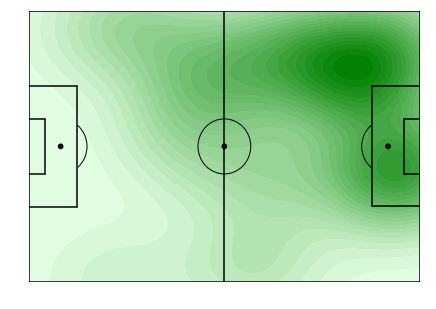

In [53]:
fig=plt.figure()
fig.set_size_inches(7, 5)
ax=fig.add_subplot(1,1,1)
draw_pitch(ax)
plt.axis('off')
x_cr = []
y_cr = []
for k in range (len(eventscr)):

        x_cr.append(eventscr["positions"][k][0]['x']*1.2)
        y_cr.append(80 - eventscr["positions"][k][0]['y']*0.8)

sns.kdeplot(x_cr, y_cr, shade = "True", color = "green", n_levels = 30)
plt.ylim(0, 80)
plt.xlim(0, 120)
plt.show()

At first sight, this map could seem quite strange. Cristiano is a forward and rarely comes back to defend but cannot we see his activity on the other side ? At each half of a match, teams switch their half of the field. Cristiano should have had more or less the same activity on the other side of the pitch. Before explaining this phenomenon, let us draw Leo Messi's map :

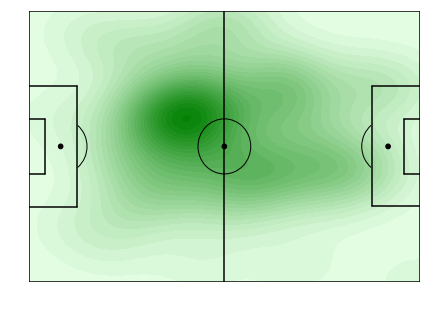

In [54]:
fig=plt.figure()
fig.set_size_inches(7, 5)
ax=fig.add_subplot(1,1,1)
draw_pitch(ax)
plt.axis('off')
x_lm = []
y_lm = []
for k in range (len(eventslm)):
    
    if (eventslm["matchPeriod"][k] == "1H"):
        
        x_lm.append(120 - eventslm["positions"][k][0]['x']*1.2)
        y_lm.append(eventslm["positions"][k][0]['y']*0.8)
        
    else :
        x_lm.append(eventslm["positions"][k][0]['x']*1.2)
        y_lm.append(eventslm["positions"][k][0]['y']*0.8) # We add 50 because the position is calculated from the left corner.
    
       

sns.kdeplot(x_lm, y_lm, shade = "True", color = "green", n_levels = 30)
plt.ylim(0, 80)
plt.xlim(0, 120)
plt.show()

**In fact, the explanation is simple : Ronaldo got injured at the end of first half so he was subbed off. That is why his activity on the other half of the field is minor.**

Aside from that, we can notice that Messi has not done any significant action in the penalty area of Real Madrid in the first half. We know that it is their penalty area because Ronaldo played only one half and he was mainly on the right side of the field, attacking. In that way, we can deduct that Barcelona struggled to attack on the first half, mainly because of Messi's low position on the field.

Lastly, these two maps confirm another facet of the rivalry Ronaldo - Messi : Messi participates way more in the beginning of the actions than Ronaldo. Despite having scored, we can see that Messi touched a lot of balls around the middle of the pitch. On the contrary, Ronaldo has almost always been more advanced on the pitched and often on the wings.

**Let us now go to Serie A and focus on a game : Juventus - Napoli**

# 2) Juventus - Napoli

Even though Napoli collapsed after this game, it remains in the spirits as the main moment in which Juventus was about to lose its throne. Therefore, it is a really interesting game to analyze. 

We will focus on the passes done by Miralem Pjanic and Jorginho. **Please note that we only took passes into consideration, not corners or free-kicks crosses.** The question seemed to lead us to only consider passes.

In [55]:
# We recover the IDs and passes of Pjanic and Jorginho

idjuvenapoli = mseriea[mseriea["label"] == "Juventus - Napoli, 0 - 1"]["wyId"].item()

idpjanic = list(players[players["firstName"] == 'Miralem']["wyId"])[0]
idjorginho = list(players[players["shortName"] == 'Jorginho']["wyId"])[0]

passespjanic = eseriea[(eseriea["eventId"] == 8)&(eseriea["playerId"] == idpjanic)&(eseriea["matchId"] == idjuvenapoli)]
passesjorginho = eseriea[(eseriea["eventId"] == 8)&(eseriea["playerId"] == idjorginho)&(eseriea["matchId"] == idjuvenapoli)]
passespjanic.index = [i for i in range(1,len(passespjanic)+1)]
passesjorginho.index = [i for i in range(1,len(passesjorginho)+1)]

# Let us now get the accurate passes of the two players. We just have to precise the tag ID as equal to 1801
accpassespjanic = pd.DataFrame(columns = list(passespjanic.columns))
accpassesjorginho = pd.DataFrame(columns = list(passespjanic.columns))

for k in range(1,len(passesjorginho)+1):
    if ({'id': 1801} in passesjorginho["tags"][k]):
        accpassesjorginho.loc[k] = list(passesjorginho.loc[k])

for k in range(1,len(passespjanic)+1):
    if ({'id': 1801} in passespjanic["tags"][k]):
        accpassespjanic.loc[k] = list(passespjanic.loc[k])
accpassespjanic.index = [i for i in range(1,len(accpassespjanic)+1)]
accpassesjorginho.index = [i for i in range(1,len(accpassesjorginho)+1)]

Everything is set to launch the plotting part. Before starting that, we can already notice that there is no difference between the general passes and the accurate passes of Miralem Pjanic. Let us see what all that looks like on a pitch.

This code has been taken from https://github.com/tuangauss/DataScienceProjects/blob/master/Python/football_visual.ipynb.
Some parameters has been changed.

In [56]:
def heat_pass_map(data):
    
    fig=plt.figure()
    fig.set_size_inches(7, 5)
    ax=fig.add_subplot(1,1,1)
    draw_pitch(ax)
    plt.axis('off')
    x_coord = []
    y_coord = []
    
    for i in range(1,len(data)):
        # we also differentiate different half by different color
        if data["matchPeriod"][i] == "1H":
            color = "blue"
            ax.annotate("", xy = (data.iloc[i]['positions'][1]["x"]*1.2, data.iloc[i]['positions'][1]["y"]*0.8), xycoords = 'data',
                xytext = (data.iloc[i]['positions'][0]["x"]*1.2, data.iloc[i]['positions'][0]["y"]*0.8), textcoords = 'data',
                arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = color),)
            x_coord.append(data["positions"][i][0]['x']*1.2)
            y_coord.append(data["positions"][i][0]['y']*0.8)
        else :
            color = "red"
            ax.annotate("", xy = (120-data.iloc[i]['positions'][1]["x"]*1.2, data.iloc[i]['positions'][1]["y"]*0.8), xycoords = 'data',
               xytext = (120-data.iloc[i]['positions'][0]["x"]*1.2, data.iloc[i]['positions'][0]["y"]*0.8), textcoords = 'data',
               arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = color),)
            x_coord.append(120 - data["positions"][i][0]['x']*1.2)
            y_coord.append(data["positions"][i][0]['y']*0.8) # We add 50 because the position is calculated from the left corner.
    
    
   
    sns.kdeplot(x_coord, y_coord, shade = "True", color = "green", n_levels = 30)
    plt.ylim(0, 80) # need this, otherwise kde plot will go outside
    plt.xlim(0, 120)
    plt.show()

To consider the events of the players on both halfs, we took the x position and substracted it to 120. We did that because the field we printed has dimension 120x80 and the positions stored in the dataset are calculated as a percentage of the distance to the opponent's goal (as the teams change sides at half time).

Thanks to this function, we will just have to call it with the dataset of each of the two players.

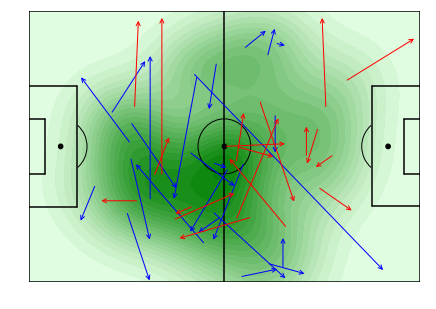

In [57]:
heat_pass_map(passespjanic)

We can see that Juve struggled to enlarge its plays and throw the balls to the wings. This is surprising knowing that Pjanic is famous for his long range passes. This could be explained by the fact that Napoli had a big game and controlled the midfield.

Let us now see the difference with all his passes and his accurate passes.

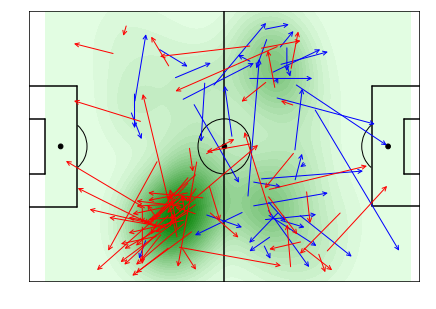

In [58]:
heat_pass_map(passesjorginho)

We can see that Jorginho has a completely different way of playing : he prefers giving short passes and gives often the ball back to the defenders. We can also see that he did a lot of passes in the same area during the second half (see the red arrows on the left).

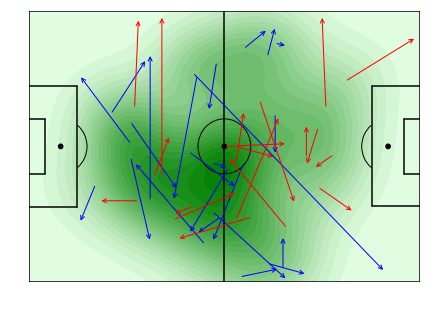

In [59]:
heat_pass_map(accpassespjanic)

We really have to look carefully to find the missed pass. It was just a lateral pass, while he succeeded in passing the ball for ALL his other attempts. Out of 44 passes, 43 were accurate !

Let us now focus on Jorginho. He made way more passes, more than the double of Pjanic's. **Does he have the same accuracy rate ?**

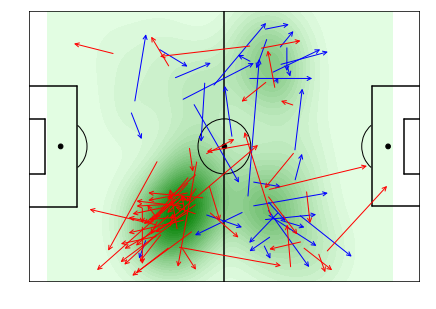

In [60]:
heat_pass_map(accpassesjorginho)

Even though he still succeeded to pass the ball many times, we can see that he missed some passes. The difference between him and Pjanic seems to be that Pjanic doesn't make a lot of passes but is accurate on almost each one of them. Moreover, he takes risks (long range passes) while Jorginho relies on short transmissions.

# Bonus : Serie A

 ### We decided to do a short study on a the ratio shots/goals of the best scorers.

A lot of strikers have a big amount of goals at the end of the season and can contend for the *capocannoniere* title. Still, is not it interesting to compare them regarding their ratio shots/goals ? We will see that some strikers are way more accurate than others.

In [61]:
g = []
eventsshots = eseriea[(eseriea["eventId"] == 10)|(eseriea["subEventId"] == 33)|(eseriea["subEventId"] == 34)|(eseriea["subEventId"] == 35)]
eventsshots.index = [i for i in range(len(eventsshots))]

for k in range(len(eventsshots)):
    
    if (len(eventsshots["tags"][k])>0):
        
        for i in range(len(eventsshots["tags"][k])):
            
            if eventsshots["tags"][k][i]["id"] == 101:
                
                g.append(eventsshots["playerId"][k])

In [62]:
uniqueid = list(set(g))
goalsperplayer = []

for k in range(len(uniqueid)):
    
    goalsperplayer.append(g.count(uniqueid[k]))

name = []
shots = []

for k in range(len(uniqueid)):
    
    name.append(list(players[players["wyId"] == uniqueid[k]]["shortName"])[0])
    shots.append(len(eventsshots[eventsshots["playerId"] == uniqueid[k]]))
    

In [63]:
scorers = pd.DataFrame(columns = ["IdPlayer","Name","Goals","NbOfShots","Ratio"])

ratio = []

for k in range(len(goalsperplayer)):
    ratio.append(goalsperplayer[k]/shots[k])

scorers["IdPlayer"] = uniqueid
scorers["Goals"] = goalsperplayer
scorers["Name"] = name
scorers["NbOfShots"] = shots
scorers["Ratio"] = ratio
scorersbis = scorers.sort_values(by ='Goals', ascending = False ).head(20)

scorersbis = scorersbis.sort_values(by ='Ratio', ascending = False )
scorersbis.index = [i for i in range(1,len(scorersbis)+1)]
scorersbis.head()

,IdPlayer,Name,Goals,NbOfShots,Ratio
1,206314,M. Icardi,29,95,0.305263
2,21384,C. Immobile,29,110,0.263636
3,86243,D. Zapata,11,51,0.215686
4,89186,P. Dybala,22,110,0.200000
5,21114,M. Antenucci,11,61,0.180328


We can see that, among the ten top scorers, Mauro Icardi has the best ratio. Ciro Immobile is quite in the same case but Icardi remains the leader in this field. He is known as a cold-blooded striker and this stat proves it. Indeed, he needs less than 4 shots to score a goal !

We can plot all the distribution of the ratios of all the scorers :

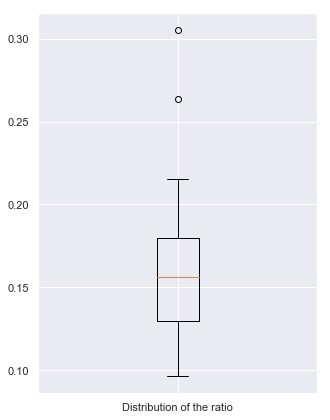

In [64]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize=(5, 7))
bplot = axes.boxplot(scorersbis["Ratio"], labels = ['Distribution of the ratio'])

We can see that the majority of the players have a ratio lower than 20%. Immobile and Icardi do not have average stats. Paradoxically, their teams had only been ranked 4th and 5th. Having an efficient striker does not seem to be enough to reach the first post !

# Conclusion

In this homework, we have been able to see how a dataset can be complex. From considering the correlation between the characteristics of the players and their performance to printing the heat maps of the players, we have handled a lot of data.

Even more than that, the interesting thing was to make decisions. The own goals were too difficult to retrieve ? We decided not to take them into consideration, as it would not impact too much our study.